<a href="https://colab.research.google.com/github/jojosam90/anomaly_detection/blob/main/ops_padim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anomalib
!pip install tarfile

In [ ]:
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz

--2022-05-18 12:52:28--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5264982680 (4.9G) [application/x-xz]
Saving to: ‘mvtec_anomaly_detection.tar.xz’

mvtec_anomaly_detec 100%[===================>]   4.90G  19.0MB/s    in 4m 28s  

2022-05-18 12:56:57 (18.7 MB/s) - ‘mvtec_anomaly_detection.tar.xz’ saved [5264982680/5264982680]



In [ ]:
import tarfile

file = tarfile.open('/content/mvtec_anomaly_detection.tar.xz')
file.extractall('/content/mvtec_anomaly')
file.close()

In [ ]:
!git clone https://github.com/openvinotoolkit/anomalib.git
%cd anomalib
!pip install -e . -q

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import os, pprint, yaml, warnings, math, glob, cv2, random, logging

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')
logger = logging.getLogger("anomalib")

import anomalib
from pytorch_lightning import Trainer, seed_everything
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import configure_logger, get_experiment_logger

In [254]:
import torch
import cv2 as cv

In [255]:
CONFIG_PATHS = '/content/anomalib/anomalib/models'
MODEL_CONFIG_PAIRS = {
    'patchcore': f'{CONFIG_PATHS}/patchcore/config.yaml',
    'padim':     f'{CONFIG_PATHS}/padim/config.yaml',
    'cflow':     f'{CONFIG_PATHS}/cflow/config.yaml',
    'dfkde':     f'{CONFIG_PATHS}/dfkde/config.yaml',
    'dfm':       f'{CONFIG_PATHS}/dfm/config.yaml',
    'ganomaly':  f'{CONFIG_PATHS}/ganomaly/config.yaml',
    'stfpm':     f'{CONFIG_PATHS}/stfpm/config.yaml',
}

In [256]:
#MODEL = 'patchcore' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
MODEL = 'padim' # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
print(open(os.path.join(MODEL_CONFIG_PAIRS[MODEL]), 'r').read())

dataset:
  name: mvtec #options: [mvtec, btech, folder]
  format: mvtec
  path: ./datasets/MVTec
  category: bottle
  task: segmentation
  image_size: 256
  train_batch_size: 32
  test_batch_size: 32
  num_workers: 36
  transform_config:
    train: null
    val: null
  create_validation_set: false
  tiling:
    apply: false
    tile_size: null
    stride: null
    remove_border_count: 0
    use_random_tiling: False
    random_tile_count: 16

model:
  name: padim
  backbone: resnet18
  layers:
    - layer1
    - layer2
    - layer3
  normalization_method: min_max # options: [none, min_max, cdf]
  threshold:
    image_default: 3
    pixel_default: 3
    adaptive: true

metrics:
  image:
    - F1Score
    - AUROC
  pixel:
    - F1Score
    - AUROC

project:
  seed: 42
  path: ./results
  log_images_to: ["local"]
  logger: false # options: [tensorboard, wandb, csv] or combinations.

optimization:
  openvino:
    apply: false

# PL Trainer Args. Don't add extra parameter here.
trainer:
  ac

In [257]:
new_update = {
    "path": '/content/mvtec_anomaly/',
    'category': 'ops', 
    'image_size': 256,
    'train_batch_size':48,
    'seed': 101
}

In [258]:
def update_yaml(old_yaml, new_yaml, new_update):
    # load yaml
    with open(old_yaml) as f:
        old = yaml.safe_load(f)
                  
    temp = []
    def set_state(old, key, value):
        if isinstance(old, dict):
            for k, v in old.items():
                if k == 'project':
                    temp.append(k)
                if k == key:
                    if temp and k == 'path':
                        # right now, we don't wanna change `project.path`
                        continue
                    old[k] = value
                elif isinstance(v, dict):
                    set_state(v, key, value)
    
    # iterate over the new update key-value pari
    for key, value in new_update.items():
        set_state(old, key, value)
    
    # save the updated / modified yaml file
    with open(new_yaml, 'w') as f:
        yaml.safe_dump(old, f, default_flow_style=False)

In [259]:
# let's set a new path location of new config file 
new_yaml = CONFIG_PATHS + '/' + list(MODEL_CONFIG_PAIRS.keys())[0] + '_new.yaml'

# run the update yaml method to update desired key's values
update_yaml(MODEL_CONFIG_PAIRS[MODEL], new_yaml, new_update)

In [260]:
with open(new_yaml) as f:new = yaml.safe_load(f)
pprint.pprint(new) # check if it's updated

{'dataset': {'category': 'ops',
             'create_validation_set': False,
             'format': 'mvtec',
             'image_size': 256,
             'name': 'mvtec',
             'num_workers': 36,
             'path': '/content/mvtec_anomaly/',
             'task': 'segmentation',
             'test_batch_size': 32,
             'tiling': {'apply': False,
                        'random_tile_count': 16,
                        'remove_border_count': 0,
                        'stride': None,
                        'tile_size': None,
                        'use_random_tiling': False},
             'train_batch_size': 48,
             'transform_config': {'train': None, 'val': None}},
 'metrics': {'image': ['F1Score', 'AUROC'], 'pixel': ['F1Score', 'AUROC']},
 'model': {'backbone': 'resnet18',
           'layers': ['layer1', 'layer2', 'layer3'],
           'name': 'padim',
           'normalization_method': 'min_max',
           'threshold': {'adaptive': True,
                   

In [261]:
if new['project']['seed'] != 0:
    print(new['project']['seed'])
    seed_everything(new['project']['seed'])

Global seed set to 101


101


In [262]:
# It will return the configurable parameters in DictConfig object.
config = get_configurable_parameters(
    model_name=new['model']['name'],
    config_path=new_yaml
)

In [263]:
model      = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks  = get_callbacks(config)
datamodule = get_datamodule(config)

In [264]:
# start training
trainer = Trainer(**config.trainer, logger=experiment_logger, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AdaptiveThreshold        | 0     
1 | pixel_threshold       | AdaptiveThreshold        | 0     
2 | training_distribution | AnomalyScoreDistribution | 0     
3 | min_max               | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [265]:
#path = '/content/mvtec_anomaly/ops/train/good/1.png'
#image = cv2.imread(path)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [266]:
#image.dtype

In [267]:
!python -m pip uninstall matplotlib 
!pip install matplotlib==3.1.3 -y


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7291666269302368
      image_F1Score          0.800000011920929
       pixel_AUROC          0.9896430373191833
      pixel_F1Score         0.20599842071533203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'image_AUROC': 0.7291666269302368,
  'image_F1Score': 0.800000011920929,
  'pixel_AUROC': 0.9896430373191833,
  'pixel_F1Score': 0.20599842071533203}]

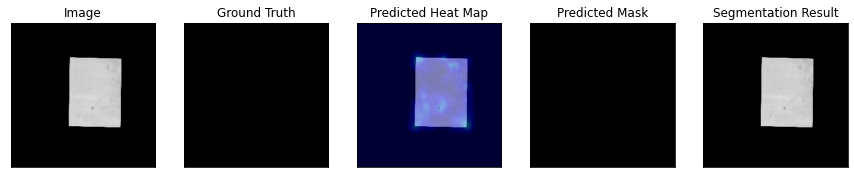

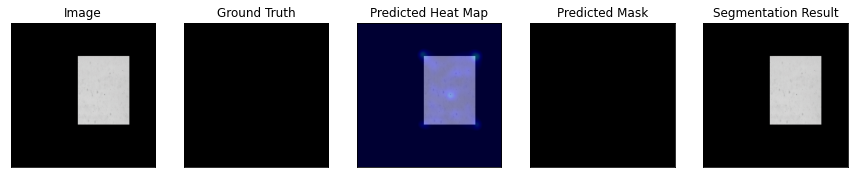

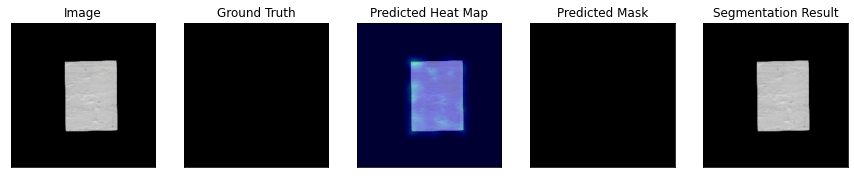

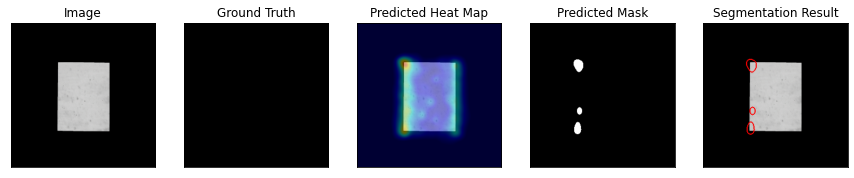

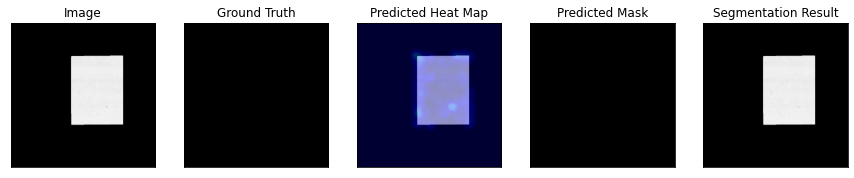

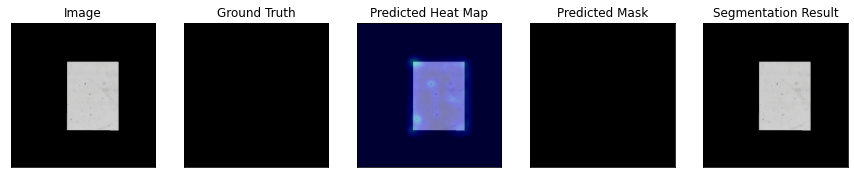

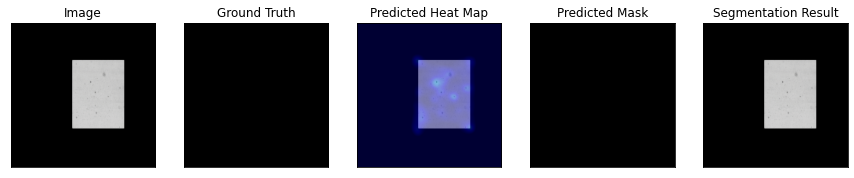

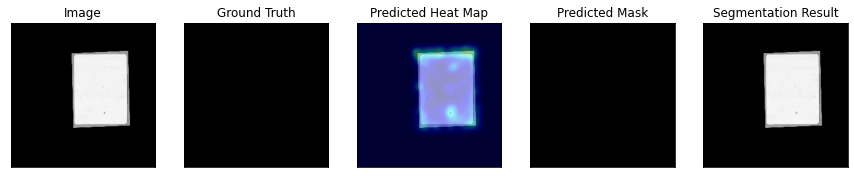

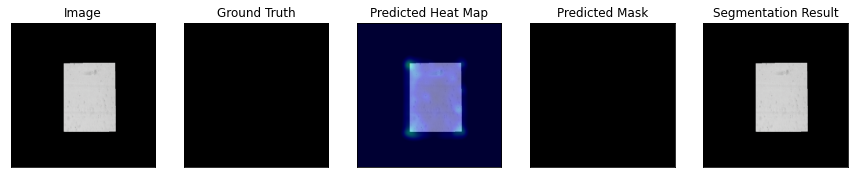

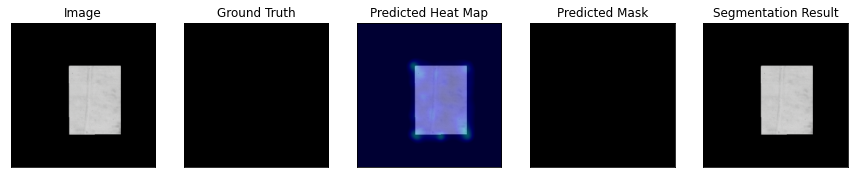

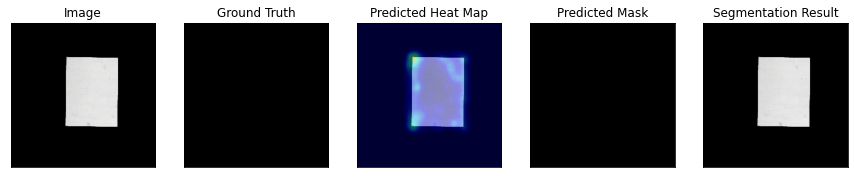

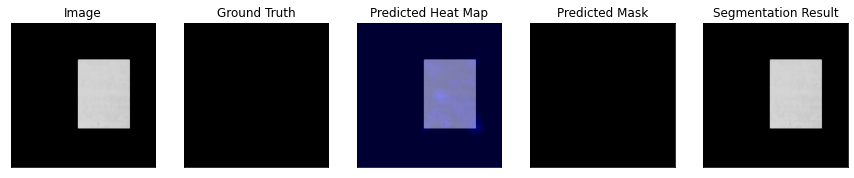

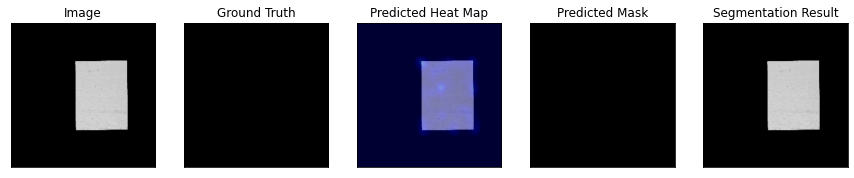

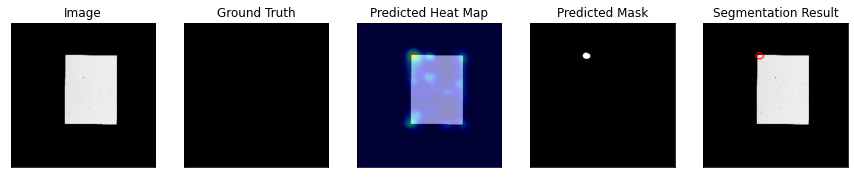

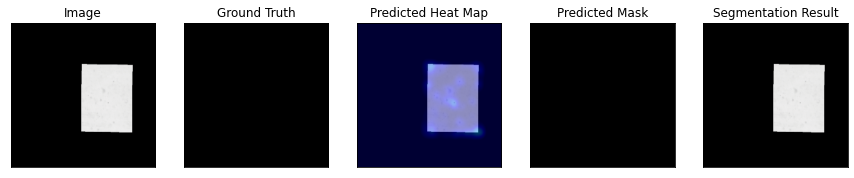

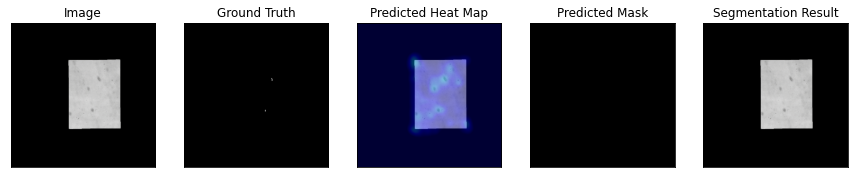

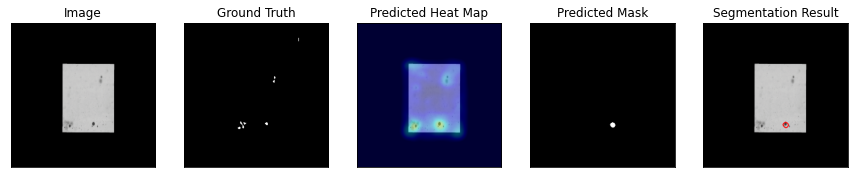

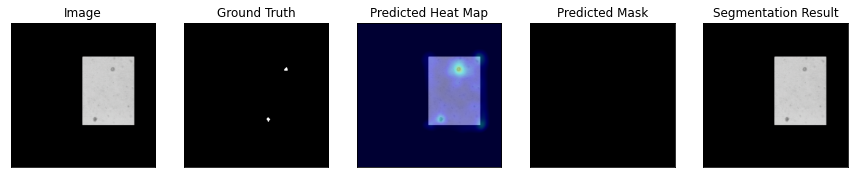

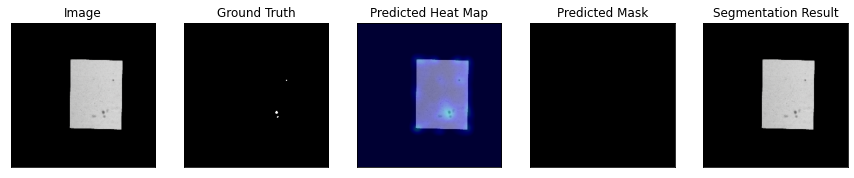

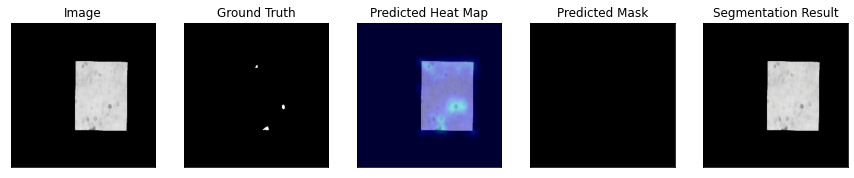

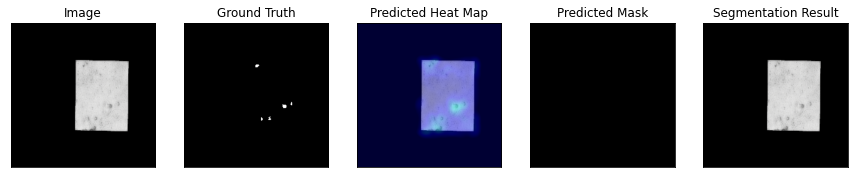

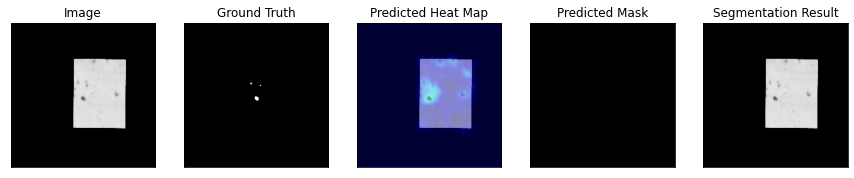

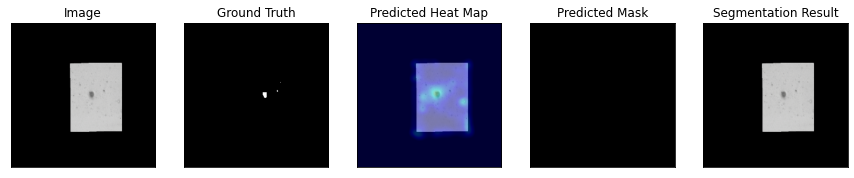

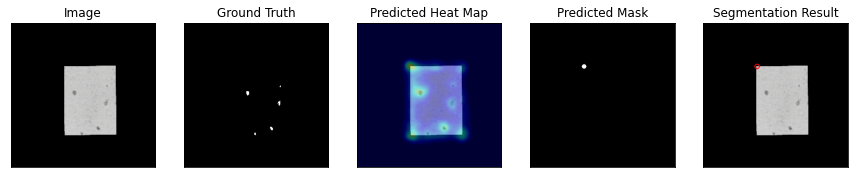

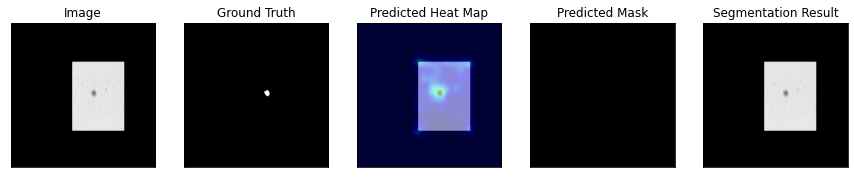

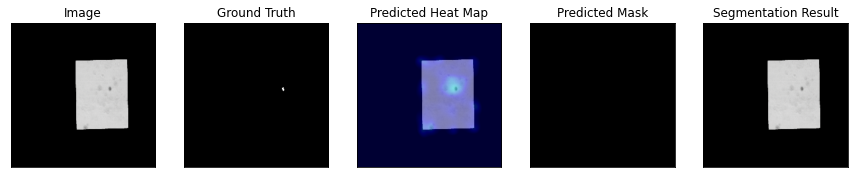

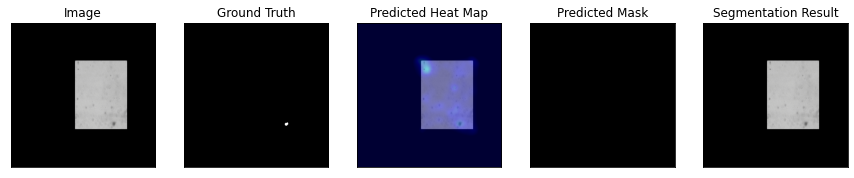

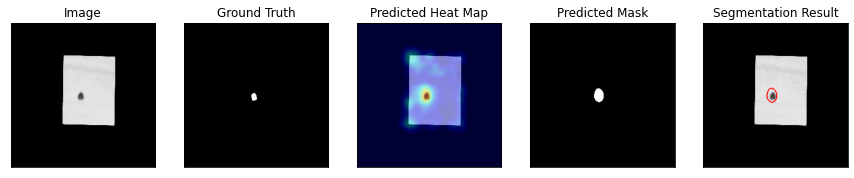

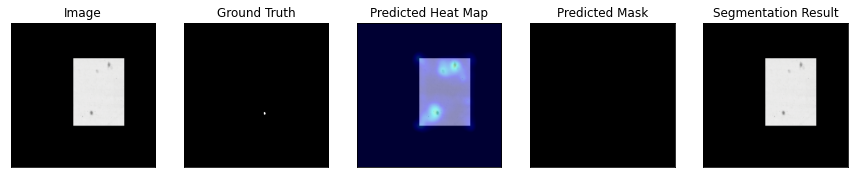

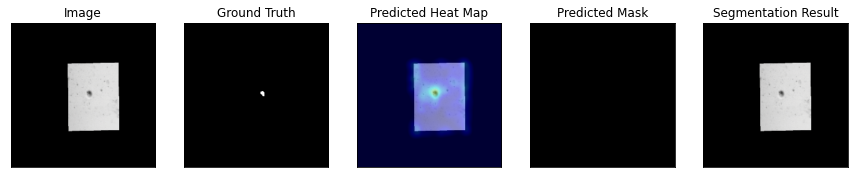

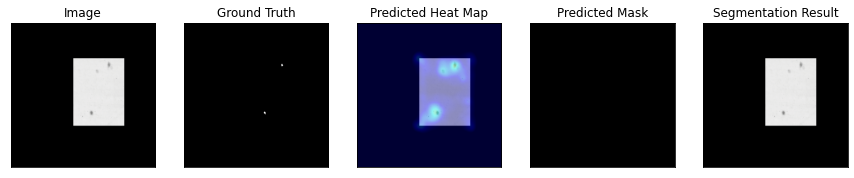

In [268]:
load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)
trainer.test(model=model, datamodule=datamodule)

In [269]:
RESULT_PATH = os.path.join(
    new['project']['path'],
    new['model']['name'],
    new['dataset']['format'], 
    new['dataset']['category']
)
RESULT_PATH

'./results/padim/mvtec/ops'

In [270]:
# a simple function to visualize the model's prediction (anomaly heatmap)
def vis(paths, n_images, is_random=True, figsize=(16, 16)):
    for i in range(n_images):
        image_name = paths[i]
        if is_random: image_name = random.choice(paths)
        img = cv2.imread(image_name)[:,:,::-1]
        
        category_type = image_name.split('/')[-4:-3:][0]
        defected_type = image_name.split('/')[-2:-1:][0]
        
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.title(
            f"Category : {category_type} and Defected Type : {defected_type}", 
            fontdict={'fontsize': 20, 'fontweight': 'medium'}
        )
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [271]:
for content in os.listdir(RESULT_PATH):
    if content == 'images':
        full_path = glob.glob(os.path.join(RESULT_PATH, content, '**',  '*.png'), recursive=True)
        print('Total Image ', len(full_path))
        print(full_path[0].split('/'))
        print(full_path[0].split('/')[-2:-1:])
        print(full_path[0].split('/')[-4:-3:])

Total Image  31
['.', 'results', 'padim', 'mvtec', 'ops', 'images', 'good', '105.png']
['good']
['ops']


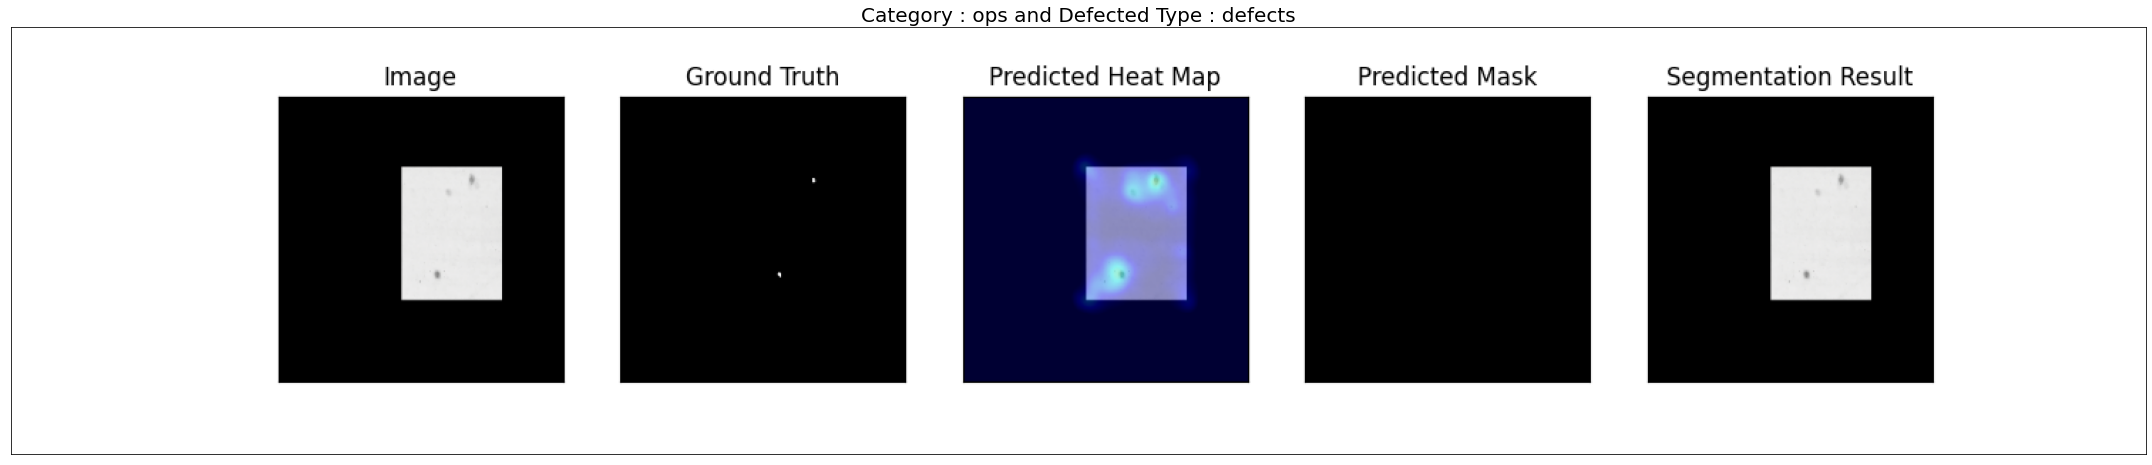

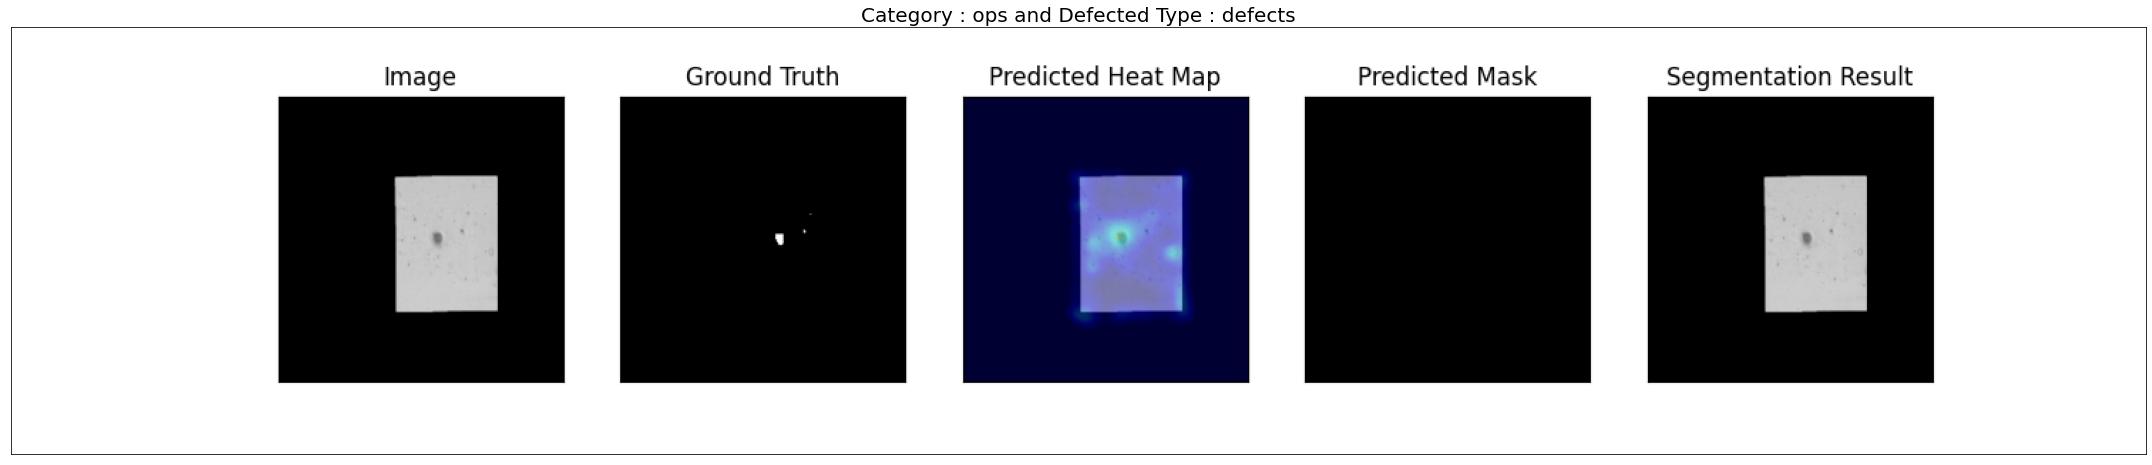

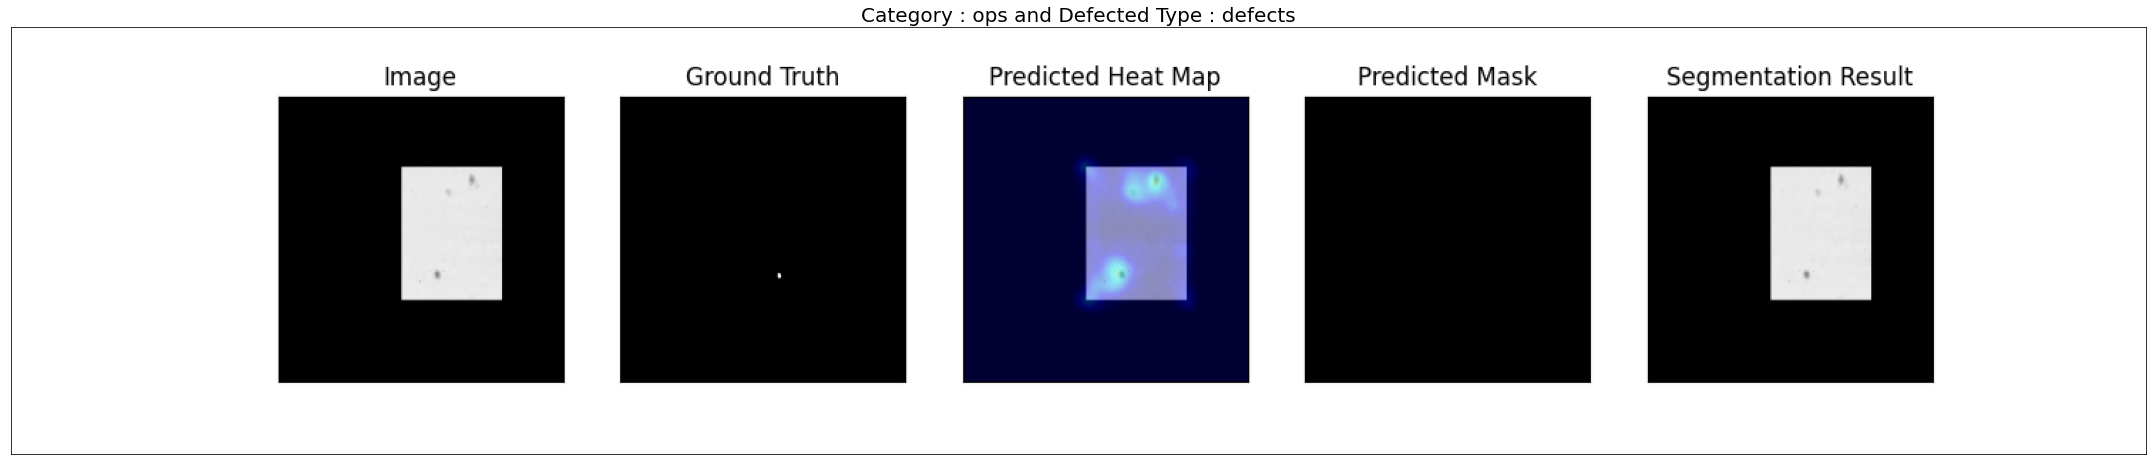

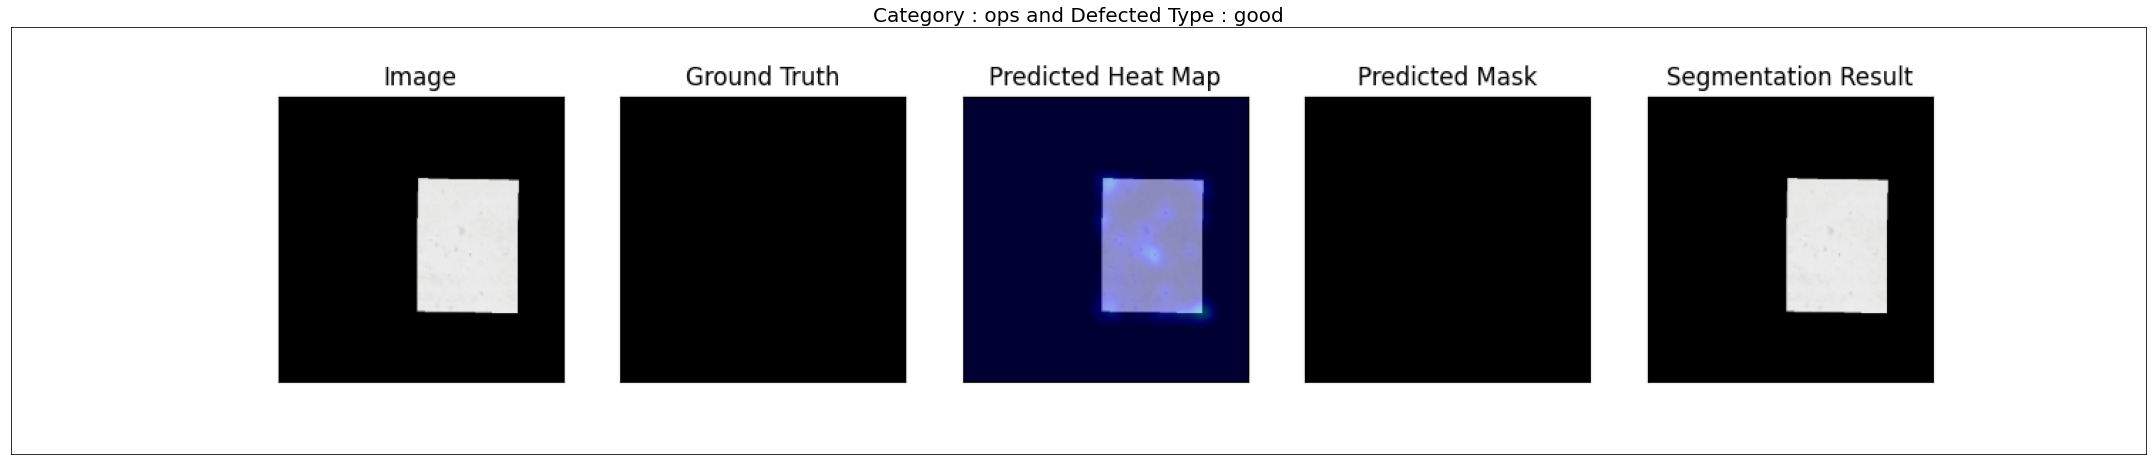

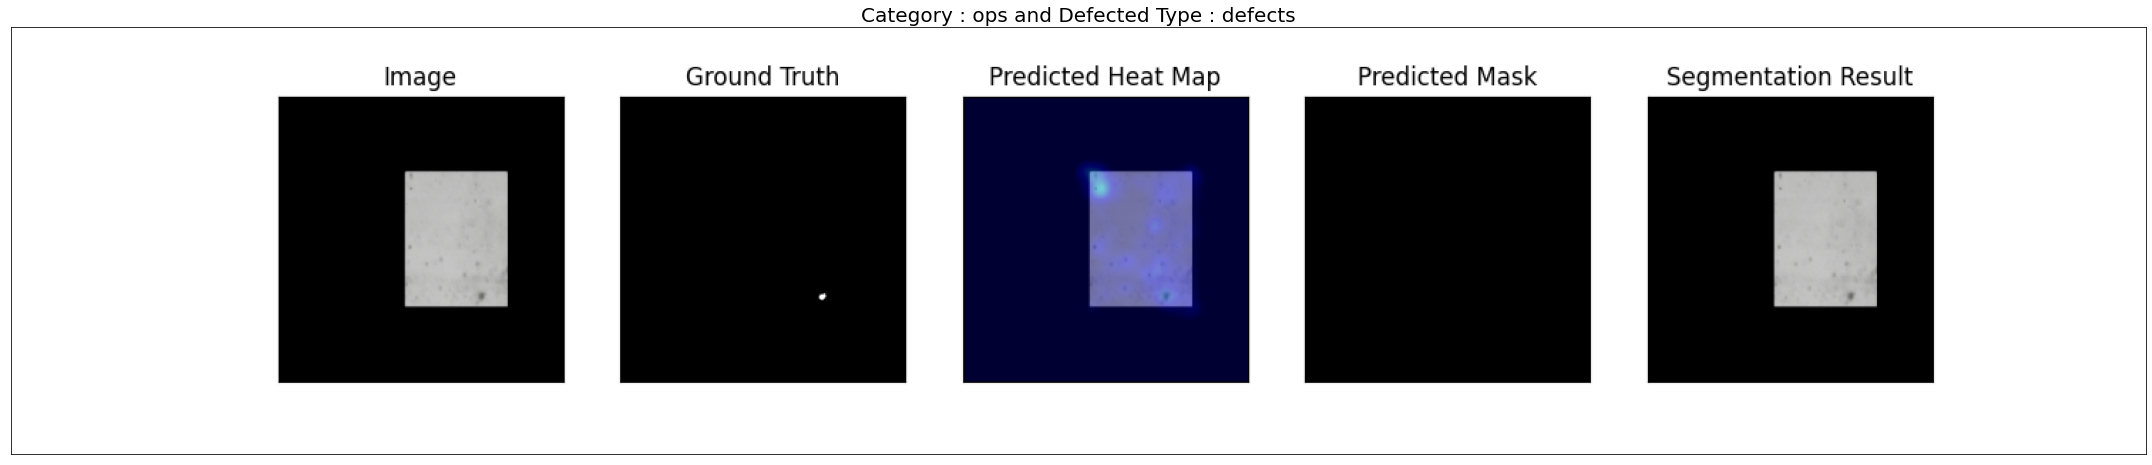

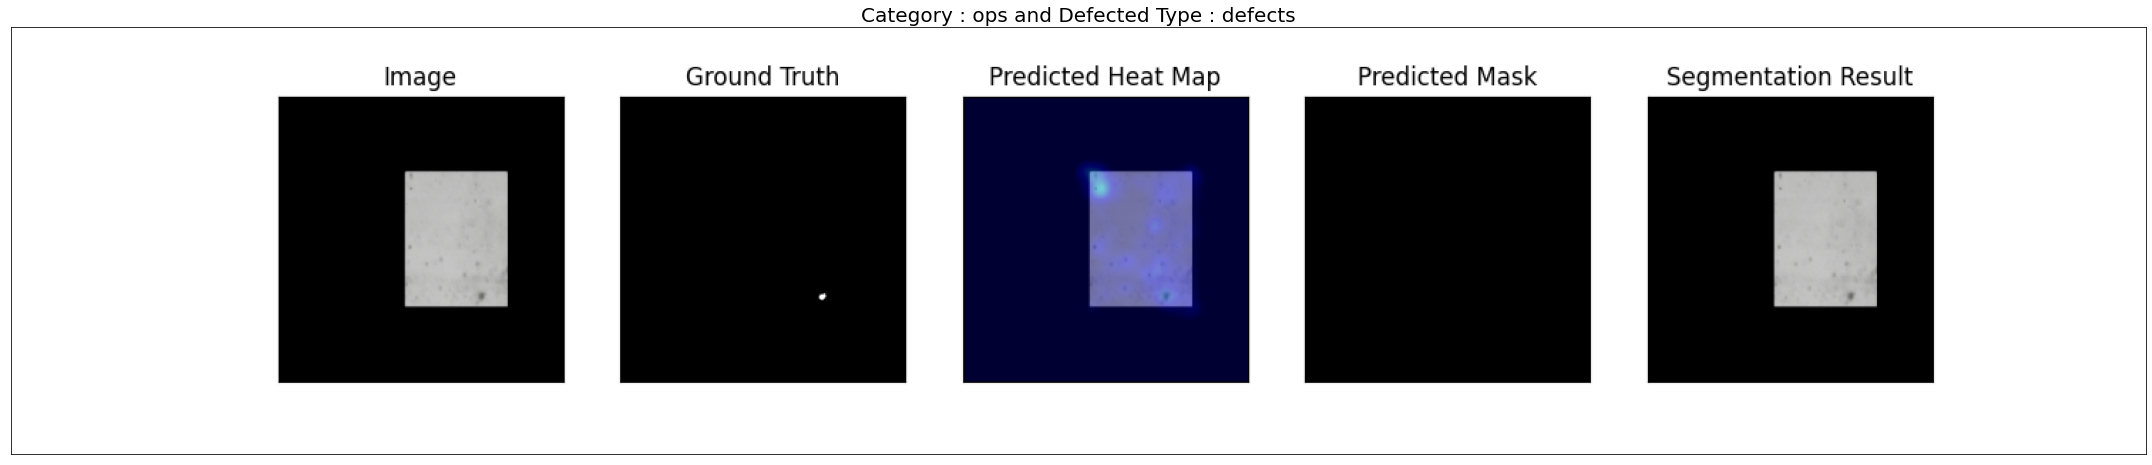

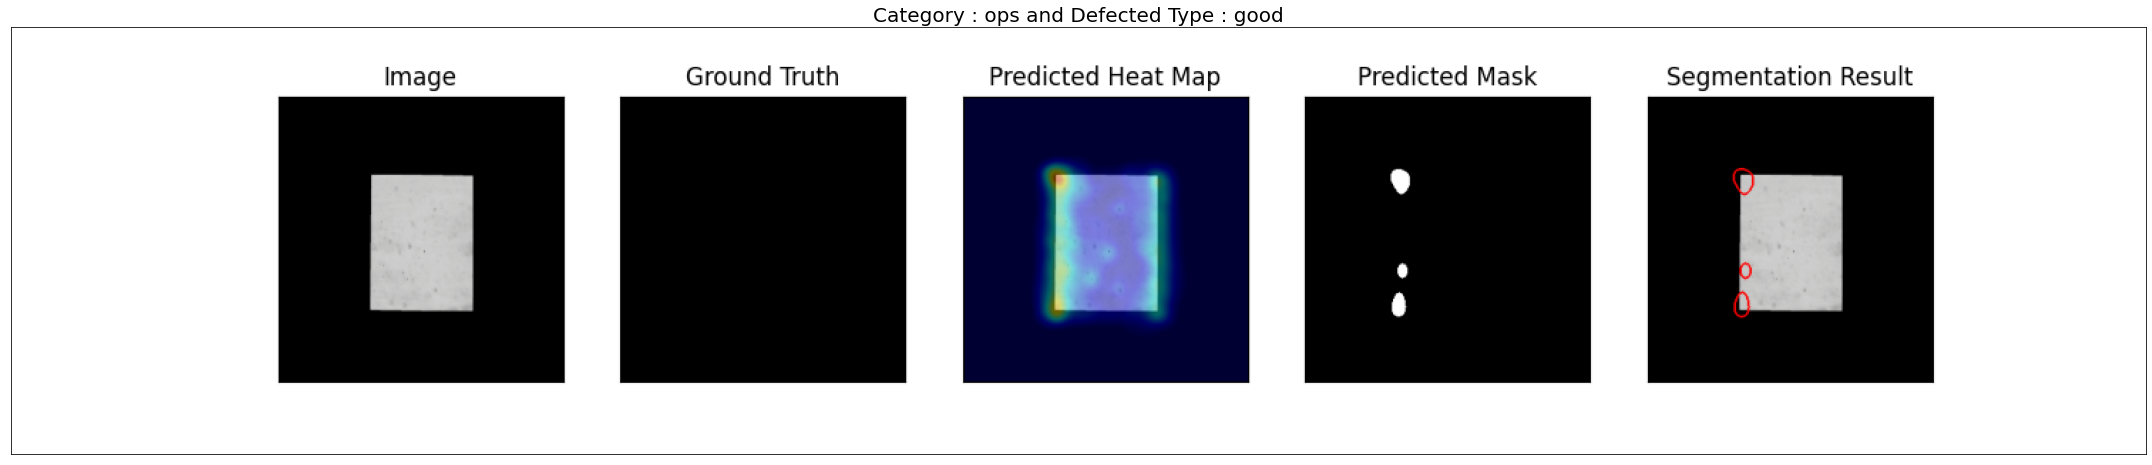

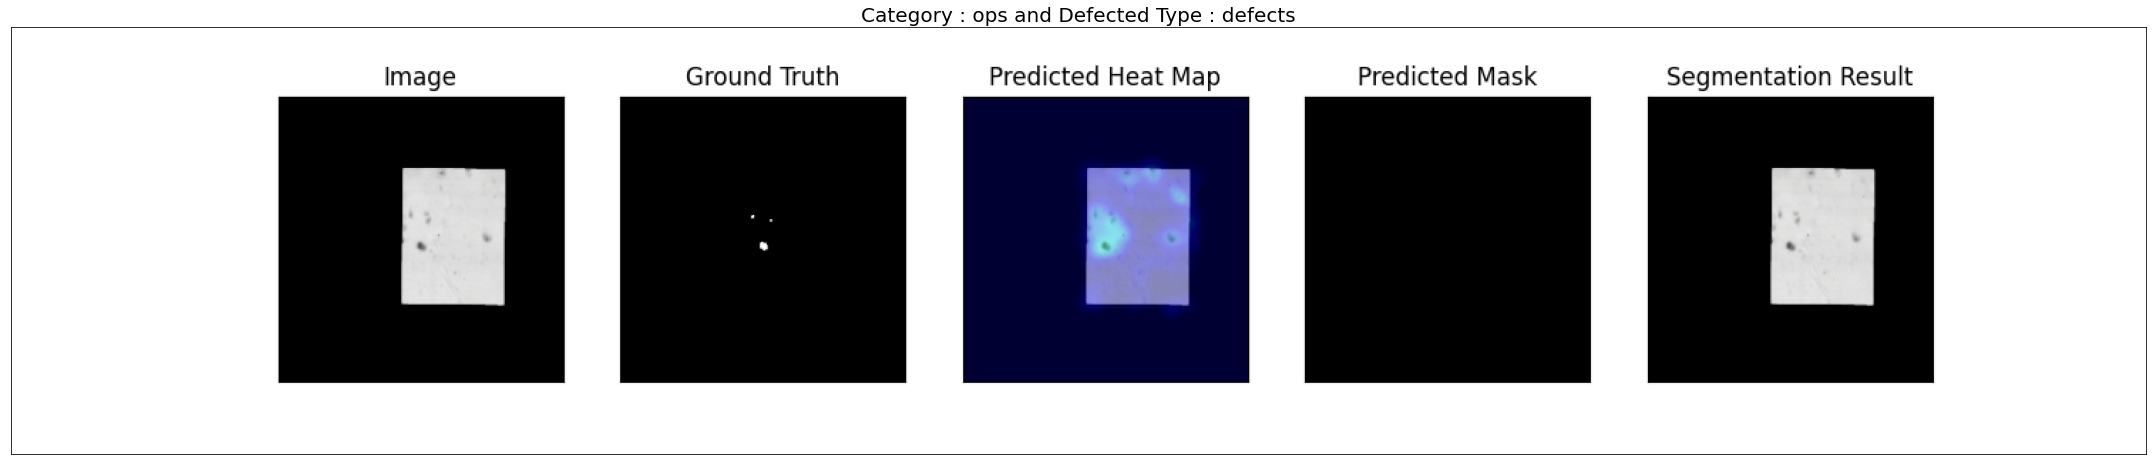

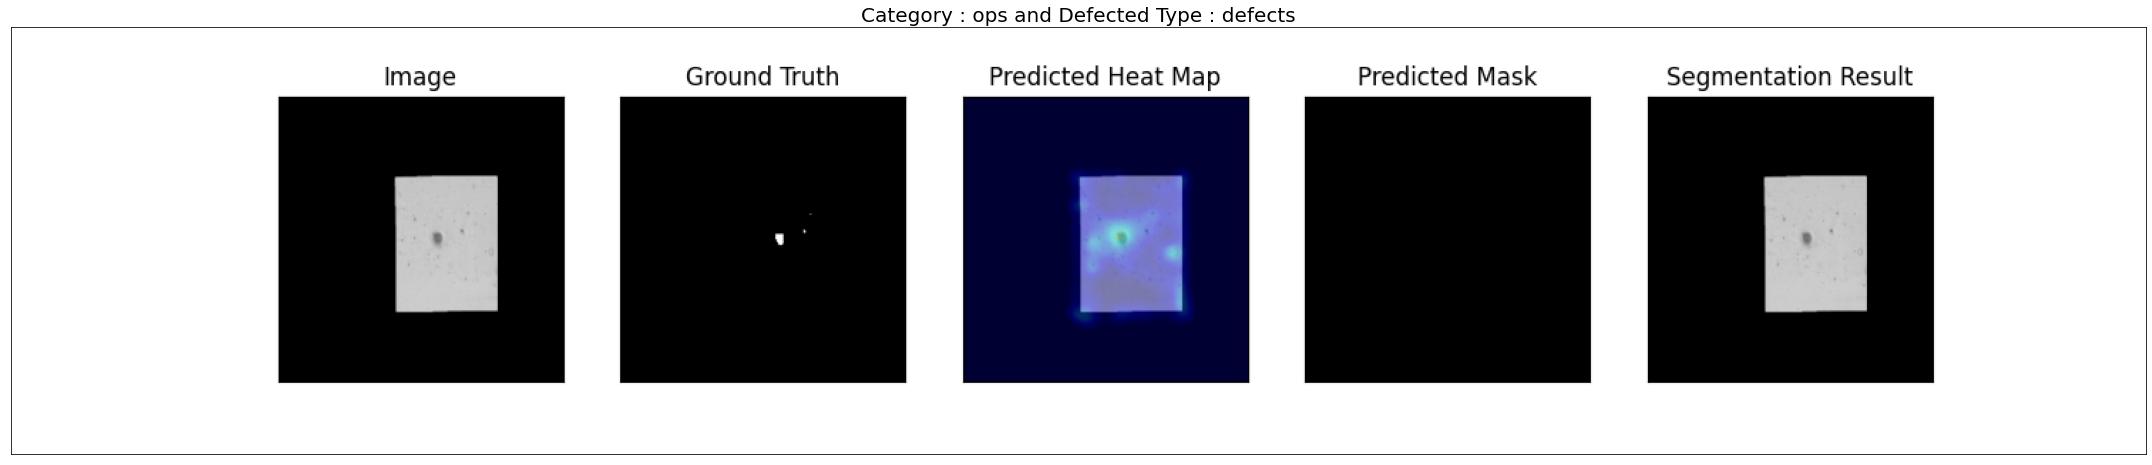

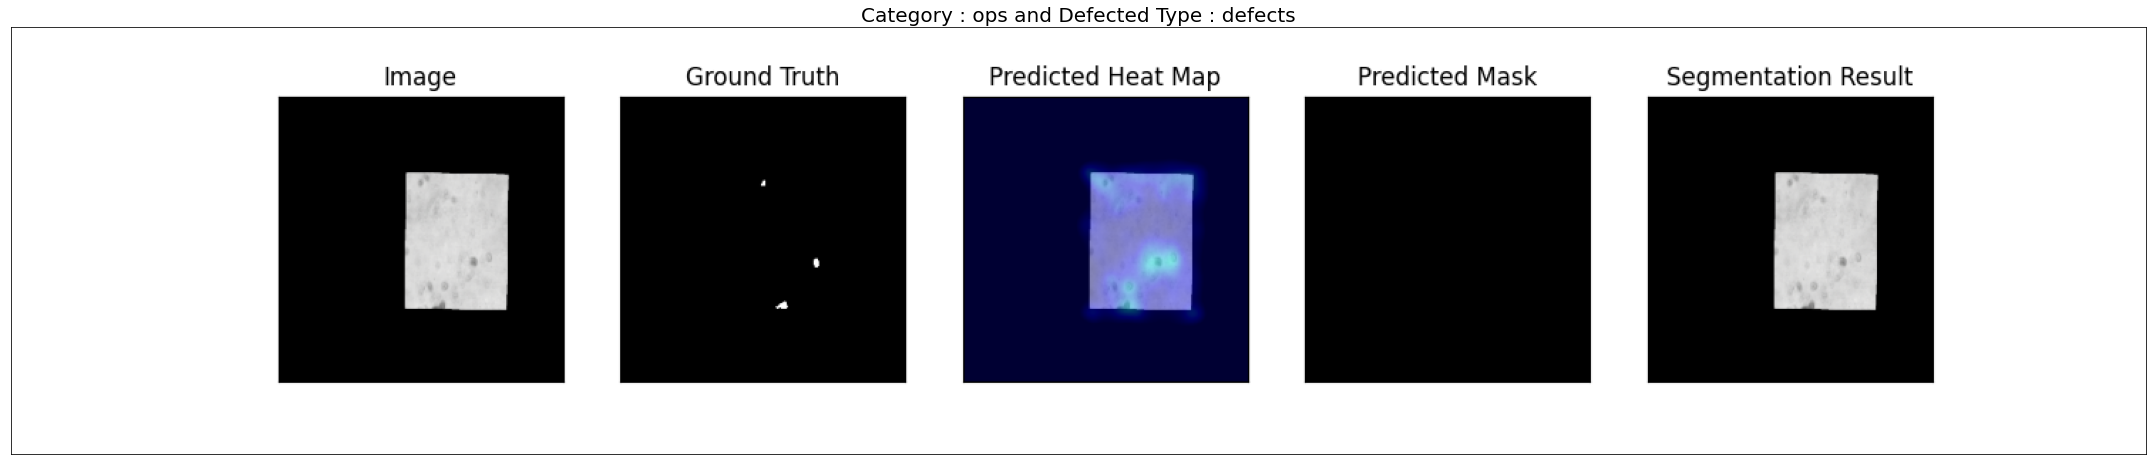

In [272]:
vis(full_path, 10, is_random=True, figsize=(30, 30))